In [1]:
# Needed to switch directory in Google drive so as to import MARL env.
from google.colab import drive 
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/"
!pwd
!pip install -r requirements.txt
!pip show tensorflow
!pip show ray

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
Obtaining gym_continuousDoubleAuction from git+https://github.com/ChuaCheowHuan/gym-continuousDoubleAuction.git@c897137cbcc93ca71cbd51c27e683c3298f6562d#egg=gym_continuousDoubleAuction (from -r requirements.txt (line 24))
  Skipping because already up-to-date.
  Found existing installation: gym-continuousDoubleAuction 0.0.1
    Can't uninstall 'gym-continuousDoubleAuction'. No files were found to uninstall.
  Running setup.py develop for gym-continuousDoubleAuction
Name: tensorflow
Version: 2.1.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['RAY_DEBUG_DISABLE_MEMORY_MONITOR'] = "True"

import argparse
import gym
import random
import numpy as np

import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.registry import register_env
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.tf.fcnet_v2 import FullyConnectedNetwork
from ray.rllib.models import Model, ModelCatalog
from ray.rllib.policy.policy import Policy
from ray.rllib.agents.ppo import ppo
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.agents.ppo.ppo_tf_policy import PPOTFPolicy
from ray.tune.logger import pretty_print

import sys
if "../" not in sys.path:
    sys.path.append("../")

from gym_continuousDoubleAuction.envs.continuousDoubleAuction_env import continuousDoubleAuctionEnv

tf = try_import_tf()

In [0]:
class CustomModel_1(Model):
    """
    Sample custom model with LSTM. 
    """

    def _lstm(self, Inputs, cell_size):
        s = tf.expand_dims(Inputs, axis=1, name='time_major')  # [time_step, feature] => [time_step, batch, feature]
        lstm_cell = tf.nn.rnn_cell.LSTMCell(cell_size)
        self.init_state = lstm_cell.zero_state(batch_size=1, dtype=tf.float32)
        # time_major means [time_step, batch, feature] while batch major means [batch, time_step, feature]
        outputs, self.final_state = tf.nn.dynamic_rnn(cell=lstm_cell, inputs=s, initial_state=self.init_state, time_major=True)
        lstm_out = tf.reshape(outputs, [-1, cell_size], name='flatten_rnn_outputs')  # joined state representation
        return lstm_out
    
    def _build_layers_v2(self, input_dict, num_outputs, options):
        hidden = 512
        cell_size = 256
        #S = input_dict["obs"]
        S = tf.layers.flatten(input_dict["obs"])
        with tf.variable_scope(tf.VariableScope(tf.AUTO_REUSE, "shared"),
                               reuse=tf.AUTO_REUSE,
                               auxiliary_name_scope=False):
            last_layer = tf.layers.dense(S, hidden, activation=tf.nn.relu, name="fc1")
        last_layer = tf.layers.dense(last_layer, hidden, activation=tf.nn.relu, name="fc2")
        last_layer = tf.layers.dense(last_layer, hidden, activation=tf.nn.relu, name="fc3")

        last_layer = self._lstm(last_layer, cell_size)

        output = tf.layers.dense(last_layer, num_outputs, activation=tf.nn.softmax, name="mu")

        return output, last_layer

In [0]:
def make_RandomPolicy(_seed):

    class RandomPolicy(Policy):
        """
        A hand-coded policy that returns random actions in the env (doesn't learn).
        """        
        
        def __init__(self, observation_space, action_space, config):
            self.observation_space = observation_space
            self.action_space = action_space
            self.action_space.seed(_seed)

        def compute_actions(self,
                            obs_batch,
                            state_batches,
                            prev_action_batch=None,
                            prev_reward_batch=None,
                            info_batch=None,
                            episodes=None,
                            **kwargs):
            """Compute actions on a batch of observations."""
            return [self.action_space.sample() for _ in obs_batch], [], {}

        def learn_on_batch(self, samples):
            """No learning."""
            #return {}
            pass

        def get_weights(self):
            pass

        def set_weights(self, weights):
            pass

    return RandomPolicy

In [5]:
# global

# Storage for on_train_result callback, use for plotting.
agt_0_reward_list = []
agt_1_reward_list = []
agt_2_reward_list = []
agt_3_reward_list = []
agt_0_NAV_list = []
agt_1_NAV_list = []
agt_2_NAV_list = []
agt_3_NAV_list = []

# RLlib config
num_workers = 1
num_envs_per_worker = 2
sample_batch_size = 32
train_batch_size = 128
num_iters = 110

# Chkpt & restore
local_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/"
chkpt_freq = 10
chkpt = 470
restore_path = "{}checkpoint_{}/checkpoint-{}".format(local_dir, chkpt, chkpt)
is_restore = True

# CDA_env args
num_agents = 4
num_trained_agent = 2 
num_policies = num_agents # Each agent is using a separate policy
num_of_traders = num_agents
tape_display_length = 10 
tick_size = 1
init_cash = 1000000
max_step = 1000 # per episode, -1 in arg.
is_render = False

# get obs & act spaces from dummy CDA env
single_CDA_env = continuousDoubleAuctionEnv(num_of_traders, init_cash, tick_size, tape_display_length, max_step, is_render)
obs_space = single_CDA_env.observation_space
act_space = single_CDA_env.action_space

# register CDA env with RLlib 
register_env("continuousDoubleAuction-v0", lambda _: continuousDoubleAuctionEnv(num_of_traders, 
                                                                                init_cash, 
                                                                                tick_size, 
                                                                                tape_display_length,
                                                                                max_step-1, 
                                                                                is_render))

# register custom model (neural network)
ModelCatalog.register_custom_model("model_disc", CustomModel_1) 

# start ray
ray.init(ignore_reinit_error=True, log_to_driver=True, webui_host='127.0.0.1', num_cpus=2) 

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-03-26 04:48:35,596	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-26 04:48:35,600	INFO resource_spec.py:212 -- Starting Ray with 6.74 GiB memory available for workers and up to 3.37 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-26 04:48:36,114	INFO services.py:1078 -- View the Ray dashboard at 127.0.0.1:8265


{'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2020-03-26_04-48-35_595784_2319/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-26_04-48-35_595784_2319/sockets/raylet',
 'redis_address': '172.28.0.2:22069',
 'session_dir': '/tmp/ray/session_2020-03-26_04-48-35_595784_2319',
 'webui_url': '127.0.0.1:8265'}

In [6]:
# Policies

def gen_policy(i):
    """
    Each policy can have a different configuration (including custom model)
    """
    config = {"model": {"custom_model": "model_disc"},
              "gamma": 0.99,}
    return (None, obs_space, act_space, config)

def policy_mapper(agent_id):
    for i in range(num_agents):
        if agent_id == i:
            return "policy_{}".format(i)


# Dictionary of policies
policies = {"policy_{}".format(i): gen_policy(i) for i in range(num_policies)}


def set_agents_policies(policies):
    """
    Set 1st policy as PPO & override all other policies as RandomPolicy with
    different seed.
    """
    
    # set all agents to use random policy
    for i in range(num_agents):
        policies["policy_{}".format(i)] = (make_RandomPolicy(i), obs_space, act_space, {})
    
    # set agent 0 & 1 to use None (PPOTFPolicy)
    offset = 2 # num of trained agents
    for i in range(num_agents-offset):
        #policies["policy_{}".format(i)] = (PPOTFPolicy, obs_space, act_space, {})
        policies["policy_{}".format(i)] = (None, obs_space, act_space, {})

    print('policies:', policies)
    return 0


set_agents_policies(policies)
policy_ids = list(policies.keys())

policies: {'policy_0': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_1': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_2': (<class '__main__.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_3': (<class '__main__.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {})}


In [0]:
def on_episode_start(info):
    """
    info["episode"] is a MultiAgentEpisode object.
    """

    episode = info["episode"] 
    print("episode {} started".format(episode.episode_id))

    # hist_data dicts at 100 items max, will auto replace old with new item at 1st index.
    episode.hist_data["agt_0_NAV"] = []
    episode.hist_data["agt_1_NAV"] = []
    episode.hist_data["agt_2_NAV"] = []
    episode.hist_data["agt_3_NAV"] = []            

In [0]:
def on_episode_end(info):
    """
    arg: {"env": .., "episode": ...}
    """

    episode = info["episode"]
    print("on_episode_end episode_id={}, length={}".format(episode.episode_id, episode.length))   
    
    last_info_0 = episode.last_info_for(0)
    last_info_1 = episode.last_info_for(1)
    last_info_2 = episode.last_info_for(2)
    last_info_3 = episode.last_info_for(3)

    episode.hist_data["agt_0_NAV"].append(last_info_0["NAV"])   
    episode.hist_data["agt_1_NAV"].append(last_info_1["NAV"])   
    episode.hist_data["agt_2_NAV"].append(last_info_2["NAV"])   
    episode.hist_data["agt_3_NAV"].append(last_info_3["NAV"])        

In [0]:
def get_max_reward_ind(info):
    """
    Get index of the max reward of the trained policies in most recent episode.
    """

    recent_policies_rewards = []
    i = 0
    offset = 2 # 1st 2 items are non-related
    for k, v in info['result']['hist_stats'].items():
        if i >= offset and i < offset + num_trained_agent:
            recent_policies_rewards.append(v[0])
        i = i + 1 
    max_reward_ind = np.argmax(recent_policies_rewards)
    return max_reward_ind    

In [0]:
def get_max_reward_policy_name(policies, max_reward_ind):
    """
    Get the policy name of the trained policy with the max reward in most recent episode.
    """

    train_policies_name = []
    i = 0
    for k,v in policies.items():
        if i < num_trained_agent:
            train_policies_name.append(k)
        i = i + 1
    max_reward_policy_name = train_policies_name[max_reward_ind]
    return train_policies_name, max_reward_policy_name

In [0]:
def _cp_weight(trainer, src, dest):
    """
    Copy weights of source policy to destination policy.
    """
    
    P0key_P1val = {}
    for (k,v), (k2,v2) in zip(trainer.get_policy(dest).get_weights().items(), 
                              trainer.get_policy(src).get_weights().items()):            
        P0key_P1val[k] = v2

    trainer.set_weights({dest:P0key_P1val, 
                         src:trainer.get_policy(src).get_weights()})

    for (k,v), (k2,v2) in zip(trainer.get_policy(dest).get_weights().items(), 
                              trainer.get_policy(src).get_weights().items()):            
        assert (v == v2).all()    

In [0]:
def cp_weight(trainer, train_policies_name, max_reward_policy_name):
    """
    Copy weights of winning policy to weights of other trained policies.
    Winning is defined as getting max reward in the current episode.
    """

    for name in train_policies_name:
        if name != max_reward_policy_name:
            _cp_weight(trainer, max_reward_policy_name, name)   

In [0]:
def all_eps_reward(info):
    agt_0_reward_list.append(info["result"]["hist_stats"]["policy_policy_0_reward"][0])
    agt_1_reward_list.append(info["result"]["hist_stats"]["policy_policy_1_reward"][0])
    agt_2_reward_list.append(info["result"]["hist_stats"]["policy_policy_2_reward"][0]) 
    agt_3_reward_list.append(info["result"]["hist_stats"]["policy_policy_3_reward"][0])

    print("agt_0_reward_list[0] = {}".format(agt_0_reward_list[0]))     
    print("agt_1_reward_list[1] = {}".format(agt_1_reward_list[0]))     
    print("agt_2_reward_list[2] = {}".format(agt_2_reward_list[0]))     
    print("agt_3_reward_list[3] = {}".format(agt_3_reward_list[0]))        

In [0]:
def all_eps_NAV(info):
    agt_0_NAV_list.append(info["result"]["hist_stats"]["agt_0_NAV"][0]) 
    agt_1_NAV_list.append(info["result"]["hist_stats"]["agt_1_NAV"][0]) 
    agt_2_NAV_list.append(info["result"]["hist_stats"]["agt_2_NAV"][0]) 
    agt_3_NAV_list.append(info["result"]["hist_stats"]["agt_3_NAV"][0]) 
           
    print("agt_0_NAV_list[0] = {}".format(agt_0_NAV_list[0]))     
    print("agt_0_NAV_list[1] = {}".format(agt_1_NAV_list[0]))     
    print("agt_0_NAV_list[2] = {}".format(agt_2_NAV_list[0]))     
    print("agt_0_NAV_list[3] = {}".format(agt_3_NAV_list[0])) 

In [0]:
def on_train_result(info):
    """
    info["trainer"] is the trainer object.

    info["result"] contains a bunch of info such as episodic rewards 
    for each policy in info["result"][hist_stats] dictionary.
    """

    # you can mutate the result dict to add new fields to return
    info["result"]["callback_ok"] = True
    
    trainer = info["trainer"] 
    max_reward_ind = get_max_reward_ind(info)
    train_policies_name, max_reward_policy_name = get_max_reward_policy_name(policies, max_reward_ind)
    cp_weight(trainer, train_policies_name, max_reward_policy_name)    
    all_eps_NAV(info)
    all_eps_reward(info)
    
    print("on_train_result ********** info['result'] {}".format(info["result"]))        

In [16]:
# Training

def my_pyAPI_train():    
    config = ppo.DEFAULT_CONFIG.copy()
    config["multiagent"] = {"policies_to_train": ["policy_0", "policy_1"],
                            "policies": policies,
                            "policy_mapping_fn": policy_mapper,
                           }    
    config["num_workers"] = num_workers
    config["num_envs_per_worker"] = num_envs_per_worker  
    config["batch_mode"] = "complete_episodes"
    config["train_batch_size"] = train_batch_size # Training batch size, if applicable. Should be >= rollout_fragment_length.
                                     # Samples batches will be concatenated together to a batch of this size,
                                     # which is then passed to SGD.
    config["sample_batch_size"] = sample_batch_size # DEPRECATED_VALUE,
    config["log_level"] = "WARN"
    config["callbacks"] = {"on_episode_start": on_episode_start, 
                           "on_episode_step": None, 
                           "on_episode_end": on_episode_end, 
                           "on_sample_end": None,
                           "on_postprocess_traj": None,
                           "on_train_result": on_train_result,}

    trainer = ppo.PPOTrainer(config=config, env="continuousDoubleAuction-v0")
    if is_restore == True:
        trainer.restore(restore_path) 

    global hist_stats_len
    for i in range(num_iters):
        result = trainer.train()
        #print(result["custom_metrics"])
        #print(pretty_print(result))
        print("training loop = ", i + 1)        
        hist_stats_len = i + 1
        
        if i % chkpt_freq == 0:
            checkpoint = trainer.save(local_dir)
            print("checkpoint saved at", checkpoint)
    
    checkpoint = trainer.save(local_dir)
    print("checkpoint saved at", checkpoint)


# run everything
my_pyAPI_train()            

2020-03-26 04:48:37,549	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-03-26 04:48:37,716	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)


/usr/local/lib/python3.6/dist-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
(pid=2399) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32

2020-03-26 04:48:57,986	INFO trainable.py:178 -- _setup took 20.281 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-03-26 04:48:57,991	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-03-26 04:48:58,469	WARNING trainable.py:210 -- Getting current IP.
2020-03-26 04:48:58,475	INFO trainable.py:416 -- Restored on 172.28.0.2 from checkpoint: /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_320/checkpoint-320
2020-03-26 04:48:58,479	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 320, '_timesteps_total': 320000, '_time_total': 1959.6714487075806, '_episodes_total': 320}


(pid=2399) episode 414315888 started
(pid=2399) episode 306058703 started
(pid=2399) on_episode_end episode_id=414315888, length=1000
(pid=2399) episode 1796051512 started
(pid=2399) on_episode_end episode_id=306058703, length=1000
(pid=2399) episode 83535407 started


2020-03-26 04:49:17,132	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1039527.000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:17,136	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('951644.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:17,137	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('1022247.000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:17,139	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_3_NAV=[Decimal('986582.0000000000000000000000')]) via TBXLogger!


agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -352591671.90726364, 'episode_reward_min': -352591671.90726364, 'episode_reward_mean': -352591671.90726364, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -63346721.28275077, 'policy_1': -85208028.72049813, 'policy_2': -117621065.23685117, 'policy_3': -86415856.66716312}, 'policy_reward_max': {'policy_0': -63346721.28275077, 'policy_1': -85208028.72049813, 'policy_2': -117621065.23685117, 'policy_3': -86415856.66716312}, 'policy_reward_mean': {'policy_0': -63346721.28275077, 'policy_1': -85208028.72049813, 'policy_2': -1

2020-03-26 04:49:21,195	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('993084.0000000000000000000000'), Decimal('1039527.000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:21,196	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('997976.0000000000000000000000'), Decimal('951644.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:21,201	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('990992.0000000000000000000000'), Decimal('1022247.000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:21,202	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_3_NAV=[Decimal('1017948.000000000000000000000'), Decimal('986582.0000000000000000000000')]) via TBXLogger!


agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -186636417.40677834, 'episode_reward_min': -352591671.90726364, 'episode_reward_mean': -269614044.657021, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -63346721.28275077, 'policy_1': -85208028.72049813, 'policy_2': -117621065.23685117, 'policy_3': -86415856.66716312}, 'policy_reward_max': {'policy_0': -39966670.363346815, 'policy_1': -22000074.8164826, 'policy_2': -45812955.108218044, 'policy_3': -78856717.11873077}, 'policy_reward_mean': {'policy_0': -51656695.82304879, 'policy_1': -53604051.76849037, 'policy_2': -817

2020-03-26 04:49:30,213	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005291.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:30,214	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('991937.0000000000000000000000'), Decimal('951644.0000000000000000000000'), Decimal('997976.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:30,216	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('995610.0000000000000000000000'), Decimal('1022247.000000000000000000000'), Decimal('990992.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:30,218	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_3_NAV=[Decimal('1007162.000000000000000000000'), Decimal('986582.0000000000000000000000'), Decimal('1

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -186636417.40677834, 'episode_reward_min': -427573713.7386578, 'episode_reward_mean': -322267267.68423325, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -63346721.28275077, 'policy_1': -85208028.72049813, 'policy_2': -256222269.44505832, 'policy_3': -86415856.66716312}, 'policy_reward_max': {'policy_0': -39966670.363346815, 'policy_1': -22000074.8164826, 'policy_2': -45812955.108218044, 'policy_3': -69132731.7640778}, 'policy_reward_mean': {'policy_0': -51059286.11257597, 'policy_1': -53187449.79162403, 'policy_2': -139

2020-03-26 04:49:34,136	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1025691.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:34,142	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('998365.0000000000000000000000'), Decimal('951644.0000000000000000000000'), Decimal('997976.0000000000000000000000'), Decimal('991937.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:34,143	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('998163.0000000000000000000000'), Decimal('1022247.000000000000000000000'), Decimal('990992.0000000000000000000000'), Decimal('995610.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:34,144	WARNING logger.py:221 -- You are trying to log an invalid value 

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -186636417.40677834, 'episode_reward_min': -609186357.1842077, 'episode_reward_mean': -393997040.0592268, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -146687385.10350844, 'policy_2': -256222269.44505832, 'policy_3': -175736103.09725633}, 'policy_reward_max': {'policy_0': -39966670.363346815, 'policy_1': -22000074.8164826, 'policy_2': -45812955.108218044, 'policy_3': -69132731.7640778}, 'policy_reward_mean': {'policy_0': -57330090.13442572, 'policy_1': -76562433.61959514, 'policy_2': -15

2020-03-26 04:49:42,930	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('987378.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:42,931	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1009553.000000000000000000000'), Decimal('951644.0000000000000000000000'), Decimal('997976.0000000000000000000000'), Decimal('991937.0000000000000000000000'), Decimal('998365.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:42,937	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('964047.0000000000000000000000'), Decimal('1022247.000000000000000000000'), Decimal('990992.0000000000000000000000'), Decimal('995610.0000000000000000000000'), Decimal('998163.0000

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -174646947.97861248, 'episode_reward_min': -609186357.1842077, 'episode_reward_mean': -350127021.64310396, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -146687385.10350844, 'policy_2': -256222269.44505832, 'policy_3': -175736103.09725633}, 'policy_reward_max': {'policy_0': -23554616.236783758, 'policy_1': -22000074.8164826, 'policy_2': -36303971.53826271, 'policy_3': -44948721.77168717}, 'policy_reward_mean': {'policy_0': -50574995.35489733, 'policy_1': -75217874.5820519, 'policy_2': -13

2020-03-26 04:49:46,556	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('986285.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:46,558	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('972404.0000000000000000000000'), Decimal('951644.0000000000000000000000'), Decimal('997976.0000000000000000000000'), Decimal('991937.0000000000000000000000'), Decimal('998365.0000000000000000000000'), Decimal('1009553.000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:46,564	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('1008115.000000000000000000000'), Decimal('1022247.000000000000000000000'), Decimal('990992.0000

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -174646947.97861248, 'episode_reward_min': -609186357.1842077, 'episode_reward_mean': -333869986.297448, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -146687385.10350844, 'policy_2': -256222269.44505832, 'policy_3': -175736103.09725633}, 'policy_reward_max': {'policy_0': -23554616.236783758, 'policy_1': -22000074.8164826, 'policy_2': -36303971.53826271, 'policy_3': -44948721.77168717}, 'policy_reward_mean': {'policy_0': -50323834.73769084, 'policy_1': -70422706.15802765, 'policy_2': -125

2020-03-26 04:49:55,204	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('995364.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:55,205	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1023689.000000000000000000000'), Decimal('951644.0000000000000000000000'), Decimal('997976.0000000000000000000000'), Decimal('991937.0000000000000000000000'), Decimal('998365.0000000000000000000000'), Decimal('1009553.000000000000000000000'), Decimal('972404.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:55,207	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('990101.0000

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -152339859.30011064, 'episode_reward_min': -609186357.1842077, 'episode_reward_mean': -307937111.01211405, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -146687385.10350844, 'policy_2': -256222269.44505832, 'policy_3': -175736103.09725633}, 'policy_reward_max': {'policy_0': -23554616.236783758, 'policy_1': -22000074.8164826, 'policy_2': -34873812.17084459, 'policy_3': -19809778.49495953}, 'policy_reward_mean': {'policy_0': -49544680.63587791, 'policy_1': -67903249.93678172, 'policy_2': -1

2020-03-26 04:49:58,867	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('981427.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:58,870	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('991868.0000000000000000000000'), Decimal('951644.0000000000000000000000'), Decimal('997976.0000000000000000000000'), Decimal('991937.0000000000000000000000'), Decimal('998365.0000000000000000000000'), Decimal('1009553.000000000000000000000'), Decimal('972404.0000000000000000000000'), Decimal('1023689.000000000000000000000')]) via TBXLogger!
2020-03-26 04:49:58,873	WARNING logger.py:221 -- You are

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -152339859.30011064, 'episode_reward_min': -792324559.2121819, 'episode_reward_mean': -368485542.03712255, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -16114278.47048622, 'policy_1': -22000074.8164826, 'policy_2': -34873812.17084459, 'policy_3': -19809778.49495953}, 'policy_reward_mean': {'policy_0': -45365880.36520395, 'policy_1': -91899603.01054245, 'policy_2': -113

2020-03-26 04:50:07,482	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('981252.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:50:07,484	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('995973.0000000000000000000000'), Decimal('951644.0000000000000000000000'), Decimal('997976.0000000000000000000000'), Decimal('991937.0000000000000000000000'), Decimal('998365.0000000000000000000000'), Decimal('1009553.000000000000000000000'), Decimal('972404.0000000000000000000000'), Decimal('1023689.000000000000000000000'), Decimal('991868.00000000000000

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -119289902.54067558, 'episode_reward_min': -792324559.2121819, 'episode_reward_mean': -340797137.6486285, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -16114278.47048622, 'policy_1': -22000074.8164826, 'policy_2': -27260483.084539708, 'policy_3': -19809778.49495953}, 'policy_reward_mean': {'policy_0': -43525192.41217825, 'policy_1': -86089978.89310257, 'policy_2': -103

2020-03-26 04:50:11,127	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1013591.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:50:11,129	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('990324.0000000000000000000000'), Decimal('951644.0000000000000000000000'), Decimal('997976.0000000000000000000000'), Decimal('991937.0000000000000000000000'), Decimal('998365.0000000000000000000000'), Decimal('1009553.000000000000000000000'), Decimal('972404.0000000000000000000000'), Decimal('1023689.0000000000000

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -119289902.54067558, 'episode_reward_min': -792324559.2121819, 'episode_reward_mean': -320424234.3033105, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -16114278.47048622, 'policy_1': -22000074.8164826, 'policy_2': -22088735.139398266, 'policy_3': -19809778.49495953}, 'policy_reward_mean': {'policy_0': -42553992.20477831, 'policy_1': -81468033.4523049, 'policy_2': -9537

2020-03-26 04:50:19,618	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1031385.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000')]) via TBXLogger!
2020-03-26 04:50:19,619	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('978308.0000000000000000000000'), Decimal('951644.0000000000000000000000'), Decimal('997976.0000000000000000000000'), Decimal('991937.0000000000000000000000'), Decimal('998365.0000000000000000000000'), Decimal('1009553.000000000000000000000'), Decimal('972404.00000000000000

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -119289902.54067558, 'episode_reward_min': -792324559.2121819, 'episode_reward_mean': -303716916.85749954, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -16114278.47048622, 'policy_1': -22000074.8164826, 'policy_2': -22088735.139398266, 'policy_3': -19809778.49495953}, 'policy_reward_mean': {'policy_0': -43879173.9838087, 'policy_1': -76286773.75201458, 'policy_2': -895

2020-03-26 04:50:23,313	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998547.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000')]) via TBXLogger!
2020-03-26 04:50:23,314	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('998943.0000000000000000000000'), Decimal('951644.0000000000000000000000'), Decimal('997976.0000000000000000000000'), Decimal('991937.0000000000000000000000'), Decimal('998365.0000000000000000000000'), Decimal('1009553.0000000000000

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -119289902.54067558, 'episode_reward_min': -792324559.2121819, 'episode_reward_mean': -297654517.73518175, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -16114278.47048622, 'policy_1': -22000074.8164826, 'policy_2': -22088735.139398266, 'policy_3': -19809778.49495953}, 'policy_reward_mean': {'policy_0': -44853736.11845667, 'policy_1': -71965746.41499813, 'policy_2': -86

2020-03-26 04:50:31,825	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1017682.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:50:31,826	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('997983.0000000000000000000000'), Decimal('951644.0000000000000000000000'), Decimal('997976.0000000000000000000000'), Decimal('991937.0000000000000000000000'), Decimal('998365.00000000000000

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -119289902.54067558, 'episode_reward_min': -792324559.2121819, 'episode_reward_mean': -285628856.751079, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -16114278.47048622, 'policy_1': -22000074.8164826, 'policy_2': -22088735.139398266, 'policy_3': -19809778.49495953}, 'policy_reward_mean': {'policy_0': -44296479.76595437, 'policy_1': -68175393.7129547, 'policy_2': -84461

2020-03-26 04:50:35,371	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1023305.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000')]) via TBXLogger!
2020-03-26 04:50:35,372	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('995221.0000000000000000000000'), Decimal('951644.0000000000000000000000'), Decimal('997976.0000000000000000000000'), Decimal('991937.00000000000000

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -119289902.54067558, 'episode_reward_min': -792324559.2121819, 'episode_reward_mean': -280345785.3714388, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -16114278.47048622, 'policy_1': -22000074.8164826, 'policy_2': -22088735.139398266, 'policy_3': -19809778.49495953}, 'policy_reward_mean': {'policy_0': -44506348.93233712, 'policy_1': -66136948.1648707, 'policy_2': -8424

2020-03-26 04:50:43,972	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1004167.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000')]) via TBXLogger!
2020-03-26 04:50:43,974	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('991846.0000000000000000000000'), Decimal('951644.0000000000000000000000'), Decimal('997976.00000000000000

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -119289902.54067558, 'episode_reward_min': -792324559.2121819, 'episode_reward_mean': -281688234.1952334, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -16114278.47048622, 'policy_1': -15559422.512645012, 'policy_2': -22088735.139398266, 'policy_3': -19809778.49495953}, 'policy_reward_mean': {'policy_0': -44696129.07828633, 'policy_1': -62765113.121388994, 'policy_2': -

2020-03-26 04:50:47,670	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1006961.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000')]) via TBXLogger!
2020-03-26 04:50:47,674	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('992060.0000000000000000000000'), Decimal('951644.00000000000000

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -117497495.94208026, 'episode_reward_min': -792324559.2121819, 'episode_reward_mean': -271426313.0544113, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -16114278.47048622, 'policy_1': -15559422.512645012, 'policy_2': -22088735.139398266, 'policy_3': -16481903.6113212}, 'policy_reward_mean': {'policy_0': -44100949.73593904, 'policy_1': -61057933.06806451, 'policy_2': -81

2020-03-26 04:50:56,348	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('991058.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000')]) via TBXLogger!
2020-03-26 04:50:56,349	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1009310.0000000000000

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -117497495.94208026, 'episode_reward_min': -792324559.2121819, 'episode_reward_mean': -262678719.73831296, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -15559422.512645012, 'policy_2': -22088735.139398266, 'policy_3': -16481903.6113212}, 'policy_reward_mean': {'policy_0': -41909241.368906595, 'policy_1': -58490280.19228187, 'policy_2': 

2020-03-26 04:50:59,911	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('994912.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:50:59,912	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -117497495.94208026, 'episode_reward_min': -792324559.2121819, 'episode_reward_mean': -257771288.57225603, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -15559422.512645012, 'policy_2': -22088735.139398266, 'policy_3': -16481903.6113212}, 'policy_reward_mean': {'policy_0': -41066432.32911719, 'policy_1': -57941685.06301572, 'policy_2': -

2020-03-26 04:51:08,499	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('999363.9999999999999999999999'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000')]) via TBXLogger!
2020-03-26 04:51:08,504	WARNING logger.py:221 -- You are trying to

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -104277099.45246519, 'episode_reward_min': -792324559.2121819, 'episode_reward_mean': -249692647.03963545, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -76142502.19997495, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -15559422.512645012, 'policy_2': -22088735.139398266, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -39698458.634792134, 'policy_1': -56611731.70535926, 'policy_2': 

2020-03-26 04:51:11,997	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1107683.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999')]) via TBXLogger!
2020-03-26 04:51:11,999	

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -104277099.45246519, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -293726953.8126787, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -15559422.512645012, 'policy_2': -22088735.139398266, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -60642166.13104466, 'policy_1': -56737316.54472844, 'policy_2': -

2020-03-26 04:51:20,464	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1002598.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -64430803.2710264, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -282808089.5011714, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -15915125.266783979, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -58131260.09829861, 'policy_1': -54714428.7413156, 'policy_2': -801

2020-03-26 04:51:24,069	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1007512.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -64430803.2710264, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -283826754.9137921, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -15915125.266783979, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -59677954.44946316, 'policy_1': -57154542.475631565, 'policy_2': -7

2020-03-26 04:51:32,725	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('997573.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -64430803.2710264, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -275999254.5592256, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -15915125.266783979, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -58520419.31373186, 'policy_1': -56069936.001221634, 'policy_2': -7

2020-03-26 04:51:36,301	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1004057.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -64430803.2710264, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -269997970.20237076, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -15915125.266783979, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -56624847.72879889, 'policy_1': -54478809.34370533, 'policy_2': -7

2020-03-26 04:51:45,029	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('985484.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -64430803.2710264, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -266616766.11276397, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -15915125.266783979, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -57127016.928194225, 'policy_1': -53782548.9138137, 'policy_2': -7

2020-03-26 04:51:48,674	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1007368.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -64430803.2710264, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -273212563.3394701, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -15915125.266783979, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -56784054.42222937, 'policy_1': -56984370.060953684, 'policy_2': -7

2020-03-26 04:51:57,139	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('992139.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -64430803.2710264, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -267932152.62629643, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -15915125.266783979, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -55103136.083040334, 'policy_1': -55478181.19653519, 'policy_2': -

2020-03-26 04:52:00,627	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1016166.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -64430803.2710264, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -274160922.8497922, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -15915125.266783979, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -60095753.403925665, 'policy_1': -55201772.04269276, 'policy_2': -7

2020-03-26 04:52:09,133	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998120.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -64430803.2710264, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -269801912.42621654, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -15915125.266783979, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -59440890.69721609, 'policy_1': -53921698.186919115, 'policy_2': -

2020-03-26 04:52:12,738	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('988540.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -64430803.2710264, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -266964124.29599252, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -15915125.266783979, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -58215565.25802324, 'policy_1': -53377901.36225418, 'policy_2': -7

2020-03-26 04:52:21,156	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('982170.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -64430803.2710264, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -264623772.86243954, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -15915125.266783979, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -58269723.88900185, 'policy_1': -52706104.38434692, 'policy_2': -7

2020-03-26 04:52:24,877	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('997850.9999999999999999999998'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -64430803.2710264, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -271390807.09141505, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -15915125.266783979, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -57349684.03311472, 'policy_1': -53005342.57366517, 'policy_2': -7

2020-03-26 04:52:33,351	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1021732.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -64430803.2710264, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -266651397.67559525, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -15752643.613592839, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -56940154.020160824, 'policy_1': -51988088.37480962, 'policy_2': -

2020-03-26 04:52:37,047	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1008336.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -64430803.2710264, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -262062476.3366717, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -15752643.613592839, 'policy_3': -14658745.4057792}, 'policy_reward_mean': {'policy_0': -55611433.906571746, 'policy_1': -51099703.97993572, 'policy_2': -7

2020-03-26 04:52:45,494	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1004835.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -256010079.13147175, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -54429367.38064446, 'policy_1': -50236800.99081405, 'policy_2': -7

2020-03-26 04:52:48,991	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005756.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -255728925.84316397, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -55205377.83335964, 'policy_1': -50325038.38785437, 'policy_2': -7

2020-03-26 04:52:57,145	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1008652.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -254884128.20783114, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -54225059.91414604, 'policy_1': -51908590.02989618, 'policy_2': -7

2020-03-26 04:53:00,552	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('996557.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -254818398.10246745, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -53475798.10095796, 'policy_1': -52024533.75874317, 'policy_2': -6

2020-03-26 04:53:08,723	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1000580.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -253895205.00997764, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -53063069.36032928, 'policy_1': -52638340.93558884, 'policy_2': -6

2020-03-26 04:53:12,272	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('984073.0000000000000000000001'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -251768891.98832107, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -52740909.508424126, 'policy_1': -51775875.11190008, 'policy_2': -

2020-03-26 04:53:20,523	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1004768.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -251208567.96618718, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -53547899.876315236, 'policy_1': -51717994.93431798, 'policy_2': -

2020-03-26 04:53:24,011	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1000480.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -246983159.65594074, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -52585422.40308722, 'policy_1': -50972776.02701896, 'policy_2': -6

2020-03-26 04:53:32,296	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1017219.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -248199514.92284775, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -52593696.45984603, 'policy_1': -50307012.42228937, 'policy_2': -6

2020-03-26 04:53:35,896	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998517.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -245549808.1316723, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -52171427.92431016, 'policy_1': -49721264.83629768, 'policy_2': -67

2020-03-26 04:53:44,381	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1011225.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -243074017.429297, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -51491848.80794091, 'policy_1': -49382852.705725074, 'policy_2': -66

2020-03-26 04:53:47,928	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('975290.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -241806415.4954174, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -14256672.673058907, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -51095316.772714674, 'policy_1': -48925689.65072004, 'policy_2': -6

2020-03-26 04:53:56,467	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('983339.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -245496058.3363718, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -12327022.670442974, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50692532.207746975, 'policy_1': -48146994.608586475, 'policy_2': -

2020-03-26 04:54:00,211	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('952173.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -244345411.986715, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -12327022.670442974, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50389504.32208709, 'policy_1': -48161887.11793727, 'policy_2': -682

2020-03-26 04:54:08,751	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1043631.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -244899849.0322085, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -12327022.670442974, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50444693.57773517, 'policy_1': -48021642.06017548, 'policy_2': -68

2020-03-26 04:54:12,390	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1017476.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -243250215.18520868, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -12327022.670442974, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50955270.45252106, 'policy_1': -47723850.92881438, 'policy_2': -6

2020-03-26 04:54:21,210	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998364.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -241893882.47613585, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -12327022.670442974, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -51259935.76630904, 'policy_1': -47402864.66954345, 'policy_2': -6

2020-03-26 04:54:24,930	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('996041.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -238341112.81442755, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -12327022.670442974, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50463514.23090386, 'policy_1': -46743926.39747587, 'policy_2': -6

2020-03-26 04:54:33,531	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1003797.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -238247915.00045222, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -12327022.670442974, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50575969.23189084, 'policy_1': -46189051.77499491, 'policy_2': -6

2020-03-26 04:54:37,528	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005126.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -236562716.06544915, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -12327022.670442974, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49864508.542342454, 'policy_1': -45914960.460785896, 'policy_2': 

2020-03-26 04:54:46,733	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('972478.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -234660354.30795187, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -12327022.670442974, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49579126.95118765, 'policy_1': -46124355.6157522, 'policy_2': -63

2020-03-26 04:54:50,425	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('987658.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -232429152.43117025, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -12327022.670442974, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49121237.612332806, 'policy_1': -45778859.85745696, 'policy_2': -

2020-03-26 04:54:59,132	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('968838.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -50228574.1546719, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -233357736.21909693, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -12327022.670442974, 'policy_2': -8449657.574336605, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49199588.16334007, 'policy_1': -45403910.01397764, 'policy_2': -6

2020-03-26 04:55:02,886	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1001962.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -230155807.71491992, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48632735.206138775, 'policy_1': -44742886.279815346, 'policy_2': 

2020-03-26 04:55:11,420	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998288.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -228554177.61250663, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -47993657.0007171, 'policy_1': -44749118.50217274, 'policy_2': -62

2020-03-26 04:55:15,024	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1056171.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -229492852.05455554, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49182242.28629351, 'policy_1': -44336127.430733755, 'policy_2': -

2020-03-26 04:55:23,357	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1000122.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -234052602.66971725, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -51008313.42878988, 'policy_1': -45853866.98798202, 'policy_2': -6

2020-03-26 04:55:26,972	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1035632.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -233015884.72764465, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -51091948.88744705, 'policy_1': -46041976.63116846, 'policy_2': -6

2020-03-26 04:55:35,478	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('999071.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -230936914.6451586, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50607745.156410575, 'policy_1': -45496018.108016066, 'policy_2': -

2020-03-26 04:55:39,120	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1025262.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -231471727.80004704, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -51268040.19449186, 'policy_1': -45278896.06899291, 'policy_2': -6

2020-03-26 04:55:47,649	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1012746.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -229928465.10118258, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50779085.18980929, 'policy_1': -44791109.08460459, 'policy_2': -6

2020-03-26 04:55:51,366	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('964670.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -232920810.13121048, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -51033685.14175128, 'policy_1': -45570438.244939834, 'policy_2': -

2020-03-26 04:56:00,357	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1032614.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -234612148.75008234, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -52332184.655504085, 'policy_1': -45637520.71458203, 'policy_2': -

2020-03-26 04:56:04,198	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1022905.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -237504949.9855163, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -52269535.76634245, 'policy_1': -45777455.338705115, 'policy_2': -6

2020-03-26 04:56:12,877	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('989754.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -235779145.68736383, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -51933614.56935527, 'policy_1': -45408755.50830741, 'policy_2': -6

2020-03-26 04:56:16,605	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1000973.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -235155138.02812117, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -259874074.5268676, 'policy_2': -256222269.44505832, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -51478591.11706746, 'policy_1': -45122256.33903698, 'policy_2': -6

2020-03-26 04:56:25,204	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998041.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -244605166.88933903, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -51075339.23729737, 'policy_1': -50608716.73324613, 'policy_2': -6

2020-03-26 04:56:28,923	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1019923.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -243978063.7712253, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50926141.582976386, 'policy_1': -50516609.66687899, 'policy_2': -6

2020-03-26 04:56:37,631	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('968110.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -244771153.4134563, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50925901.44620074, 'policy_1': -51074860.43955692, 'policy_2': -68

2020-03-26 04:56:41,358	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1007607.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -243288145.03233936, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -7064533.432564837, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50556803.94088013, 'policy_1': -50584359.3983692, 'policy_2': -67

2020-03-26 04:56:50,052	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('992797.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -242080766.5129458, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50059900.61264312, 'policy_1': -50001161.87535171, 'policy_2': -6

2020-03-26 04:56:53,769	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1007191.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -239957695.84345633, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49749870.22713273, 'policy_1': -49716370.970350854, 'policy_2': 

2020-03-26 04:57:02,580	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1003461.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -238984738.70532787, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49221815.891289085, 'policy_1': -49839940.36138123, 'policy_2': 

2020-03-26 04:57:06,189	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('995888.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -239883081.12866312, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48965727.10658886, 'policy_1': -49670296.74326767, 'policy_2': -

2020-03-26 04:57:15,020	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1080170.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -240976723.95387197, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49236822.17889568, 'policy_1': -49584844.21466666, 'policy_2': -

2020-03-26 04:57:18,649	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('985234.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -241056043.65238252, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49687764.01315771, 'policy_1': -49185387.57014329, 'policy_2': -

2020-03-26 04:57:27,226	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1022104.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -240147796.39578816, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49439284.29820811, 'policy_1': -48905326.13274598, 'policy_2': -

2020-03-26 04:57:30,805	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005060.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -239810050.1270085, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49825367.642325565, 'policy_1': -48442809.353251524, 'policy_2': 

2020-03-26 04:57:39,508	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998746.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -238652923.733305, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49576752.5567831, 'policy_1': -48132518.3870737, 'policy_2': -6616

2020-03-26 04:57:43,096	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1009673.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -236481505.46881917, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49186635.470217474, 'policy_1': -47772848.53047428, 'policy_2': 

2020-03-26 04:57:51,756	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('991757.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -236119049.82308942, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49262902.98776556, 'policy_1': -47550069.43355947, 'policy_2': -

2020-03-26 04:57:55,351	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1013517.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -235466725.81316578, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49091492.315993585, 'policy_1': -47681622.662556656, 'policy_2':

2020-03-26 04:58:04,038	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('954663.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -235959958.69061586, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48772237.78859314, 'policy_1': -48368620.66910785, 'policy_2': -

2020-03-26 04:58:07,548	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1098956.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -238203450.82002926, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49628142.680000804, 'policy_1': -49311700.75915033, 'policy_2': 

2020-03-26 04:58:16,052	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1002952.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -236652985.53904235, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49235388.387020186, 'policy_1': -49149468.72744983, 'policy_2': 

2020-03-26 04:58:19,556	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1000794.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -235437043.63882476, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48893039.29050631, 'policy_1': -48704417.33098284, 'policy_2': -

2020-03-26 04:58:27,788	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('990786.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -235359076.24491853, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48486902.49566098, 'policy_1': -48770396.35242656, 'policy_2': -

2020-03-26 04:58:31,413	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1014988.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -235109284.06601197, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48679859.454828694, 'policy_1': -48339848.478931025, 'policy_2':

2020-03-26 04:58:39,989	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('990064.9999999999999999999998'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -234887024.73629856, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48570078.40287435, 'policy_1': -48148877.78758722, 'policy_2': -

2020-03-26 04:58:43,732	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('976747.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -234501183.5564198, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48512748.19048031, 'policy_1': -48579752.86598907, 'policy_2': -6

2020-03-26 04:58:52,245	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1002690.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -233284583.52883276, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48310209.233084545, 'policy_1': -48469908.88856622, 'policy_2': 

2020-03-26 04:58:55,973	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1004592.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -231823053.54811502, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -47975137.214417644, 'policy_1': -48135322.03327546, 'policy_2': 

2020-03-26 04:59:05,115	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('991224.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -230271324.9058199, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -6844545.1720567355, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -47768983.6608312, 'policy_1': -47978091.10475889, 'policy_2': -63

2020-03-26 04:59:08,907	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1013024.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -230017162.89644372, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -47688656.518581286, 'policy_1': -47542637.4806331, 'policy_2': -6

2020-03-26 04:59:17,670	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1017358.000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -228620172.21400765, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -47478814.47044432, 'policy_1': -47181500.38002247, 'policy_2': -6

2020-03-26 04:59:21,362	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998019.0000000000000000000000'), Decimal('1039527.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -227523985.3541519, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -47260989.353438415, 'policy_1': -47007600.56723104, 'policy_2': -6

2020-03-26 04:59:30,177	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005508.000000000000000000000'), Decimal('993084.0000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -225583385.27193978, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -46812142.13366023, 'policy_1': -46620063.71012668, 'policy_2': -6

2020-03-26 04:59:34,042	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1027234.000000000000000000000'), Decimal('1005291.000000000000000000000'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -225440570.01835597, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -46767197.87303485, 'policy_1': -46639814.14956286, 'policy_2': -6

2020-03-26 04:59:43,077	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('997839.0000000000000000000001'), Decimal('1025691.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -222000079.77616388, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -46463976.0077493, 'policy_1': -46321193.062465556, 'policy_2': -5

2020-03-26 04:59:46,912	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1014174.000000000000000000000'), Decimal('987378.0000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -218701290.88962328, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -45919237.83897746, 'policy_1': -45213821.862990215, 'policy_2': -

2020-03-26 04:59:56,120	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1042900.000000000000000000000'), Decimal('986285.0000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -219636345.12488323, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -46639903.07886441, 'policy_1': -44720579.57159489, 'policy_2': -5

2020-03-26 05:00:00,042	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1048019.000000000000000000000'), Decimal('995364.0000000000000000000000'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -225912223.68926618, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48522630.19360861, 'policy_1': -48415187.20836199, 'policy_2': -6

2020-03-26 05:00:09,189	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('978213.9999999999999999999999'), Decimal('981427.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -226594125.20611188, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -400923109.25102794}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48284286.326600686, 'policy_1': -48470558.4396867, 'policy_2': -6

2020-03-26 05:00:13,105	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('987304.0000000000000000000000'), Decimal('981252.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -220298724.42768762, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -383080311.84894335}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48361791.3268666, 'policy_1': -46323626.26494885, 'policy_2': -59

2020-03-26 05:00:22,079	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('972626.0000000000000000000000'), Decimal('1013591.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -220339500.4428991, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -383080311.84894335}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48229536.30188339, 'policy_1': -46031851.99902976, 'policy_2': -59

2020-03-26 05:00:25,889	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1014806.000000000000000000000'), Decimal('1031385.000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -220952992.8646747, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -383080311.84894335}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48369529.4541114, 'policy_1': -46295153.2784975, 'policy_2': -6002

2020-03-26 05:00:34,691	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('986140.0000000000000000000000'), Decimal('998547.0000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -220975364.81401092, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -432498576.90300995, 'policy_3': -383080311.84894335}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48096748.07066818, 'policy_1': -46368122.583802745, 'policy_2': -

2020-03-26 05:00:38,415	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1028351.000000000000000000000'), Decimal('1017682.000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1130378782.5004992, 'episode_reward_mean': -229874397.2671572, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -434660944.3278867, 'policy_2': -471758719.436933, 'policy_3': -383080311.84894335}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -48952451.2750566, 'policy_1': -49815149.945180394, 'policy_2': -6407

2020-03-26 05:00:47,389	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('988946.0000000000000000000000'), Decimal('1023305.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -245692373.9962557, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -383080311.84894335}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50193809.19256121, 'policy_1': -55202795.47305777, 'policy_2': -71207

2020-03-26 05:00:51,052	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1067932.000000000000000000000'), Decimal('1004167.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -248490661.73561946, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -383080311.84894335}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50422900.25594952, 'policy_1': -56023654.70333809, 'policy_2': -7096

2020-03-26 05:00:59,758	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1001747.000000000000000000000'), Decimal('1006961.000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -247213689.72648552, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -383080311.84894335}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50116662.80307737, 'policy_1': -56012232.55113983, 'policy_2': -7069

2020-03-26 05:01:03,577	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998841.0000000000000000000000'), Decimal('991058.0000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -247163025.5417302, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -383080311.84894335}, 'policy_reward_max': {'policy_0': -6841907.4963874575, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49921611.90445846, 'policy_1': -55712280.79967559, 'policy_2': -70883

2020-03-26 05:01:12,763	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1000449.000000000000000000000'), Decimal('994912.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -255888378.65313095, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -383080311.84894335}, 'policy_reward_max': {'policy_0': -7913139.44337751, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -50161553.97380094, 'policy_1': -58774088.92365373, 'policy_2': -751583

2020-03-26 05:01:16,683	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('992546.0000000000000000000000'), Decimal('999363.9999999999999999999999'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -257186818.72917172, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -383080311.84894335}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49957925.52213576, 'policy_1': -58599128.02071404, 'policy_2': -75806

2020-03-26 05:01:25,602	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('997526.0000000000000000000000'), Decimal('1107683.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -257444558.26992577, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -458572608.5598427, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -383080311.84894335}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -49910540.28900399, 'policy_1': -58457529.168155015, 'policy_2': -7586

2020-03-26 05:01:29,435	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1010372.000000000000000000000'), Decimal('1002598.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -252645294.97174755, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -277232796.9090723}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -45646801.70817274, 'policy_1': -60901351.045069866, 'policy_2': -73940

2020-03-26 05:01:38,319	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1007420.000000000000000000000'), Decimal('1007512.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -253557777.54224396, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -277232796.9090723}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -45855826.39756591, 'policy_1': -60937279.17714783, 'policy_2': -741780

2020-03-26 05:01:42,112	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1001424.000000000000000000000'), Decimal('997573.0000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -251117160.59922287, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -277232796.9090723}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -45036295.76869555, 'policy_1': -59961351.28418435, 'policy_2': -737003

2020-03-26 05:01:50,926	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1011080.000000000000000000000'), Decimal('1004057.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -251614271.0000466, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -277232796.9090723}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -45012073.03560886, 'policy_1': -60004178.37962203, 'policy_2': -7393187

2020-03-26 05:01:54,584	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1001239.000000000000000000000'), Decimal('985484.0000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -251370498.94015867, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -277232796.9090723}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -44967497.668480545, 'policy_1': -60246688.84162262, 'policy_2': -73956

2020-03-26 05:02:03,420	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1007706.000000000000000000000'), Decimal('1007368.000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -261761453.94039539, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -46137792.30811968, 'policy_1': -59966580.04749982, 'policy_2': -801719

2020-03-26 05:02:07,262	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('999434.0000000000000000000000'), Decimal('992139.0000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -259690525.37975365, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -45950074.27447226, 'policy_1': -59267750.55632681, 'policy_2': -798993

2020-03-26 05:02:16,238	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005913.000000000000000000000'), Decimal('1016166.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -260207530.8766327, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -46032655.46947408, 'policy_1': -59219666.81847193, 'policy_2': -8051903

2020-03-26 05:02:19,947	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1024797.000000000000000000000'), Decimal('998120.0000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -258437103.6518091, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -44204815.672824904, 'policy_1': -58914202.56762696, 'policy_2': -811744

2020-03-26 05:02:28,793	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1003473.000000000000000000000'), Decimal('988540.0000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -258645141.65580377, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -44002930.83004778, 'policy_1': -59060209.086318105, 'policy_2': -81201

2020-03-26 05:02:32,493	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1046052.000000000000000000000'), Decimal('982170.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -258780801.17172945, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -44344486.64442052, 'policy_1': -59127786.932984695, 'policy_2': -81216

2020-03-26 05:02:41,304	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('976672.0000000000000000000000'), Decimal('997850.9999999999999999999998'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -258886359.16608664, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -44346919.52860396, 'policy_1': -59206621.45848982, 'policy_2': -814098

2020-03-26 05:02:45,070	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1020826.000000000000000000000'), Decimal('1021732.000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -255849162.7514377, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -44339277.94847669, 'policy_1': -58937919.45983894, 'policy_2': -7952330

2020-03-26 05:02:53,729	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('989295.0000000000000000000000'), Decimal('1008336.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -255764772.71679324, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -44045519.298526675, 'policy_1': -59081080.1550472, 'policy_2': -797807

2020-03-26 05:02:57,297	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1027854.000000000000000000000'), Decimal('1004835.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -255219844.80358338, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -6641711.720541159}, 'policy_reward_mean': {'policy_0': -44037569.39234474, 'policy_1': -58999114.73107364, 'policy_2': -793930

2020-03-26 05:03:05,932	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1091536.000000000000000000000'), Decimal('1005756.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -257607151.28865182, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -44507487.248754255, 'policy_1': -59477022.880419016, 'policy_2': -8053

2020-03-26 05:03:09,496	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1011896.000000000000000000000'), Decimal('1008652.000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -256654056.44566047, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -43995508.57124541, 'policy_1': -59398415.9426765, 'policy_2': -8058148

2020-03-26 05:03:18,110	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('990920.0000000000000000000000'), Decimal('996557.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000'), Decimal('968838.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -256587201.40321448, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -43960242.33686242, 'policy_1': -58646503.592540205, 'policy_2': -81228

2020-03-26 05:03:21,715	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('971679.0000000000000000000000'), Decimal('1000580.000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000'), Decimal('968838.0000000000000000000000'), Decimal('1001962.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -259447220.81559867, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6375833.486178906, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -44278480.36089474, 'policy_1': -58824078.08447714, 'policy_2': -826257

2020-03-26 05:03:30,080	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998799.0000000000000000000000'), Decimal('984073.0000000000000000000001'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000'), Decimal('968838.0000000000000000000000'), Decimal('1001962.000000000000000000000'), Decimal('998288.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -258701938.6557992, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6080702.501662632, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -43965493.613746956, 'policy_1': -58304687.63933012, 'policy_2': -825746

2020-03-26 05:03:33,696	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('990434.0000000000000000000000'), Decimal('1004768.000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000'), Decimal('968838.0000000000000000000000'), Decimal('1001962.000000000000000000000'), Decimal('998288.0000000000000000000000'), Decimal('1056171.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -259164457.1440214, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6080702.501662632, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -44104103.888407595, 'policy_1': -58708344.99111321, 'policy_2': -828454

2020-03-26 05:03:42,288	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('982812.0000000000000000000000'), Decimal('1000480.000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000'), Decimal('968838.0000000000000000000000'), Decimal('1001962.000000000000000000000'), Decimal('998288.0000000000000000000000'), Decimal('1056171.000000000000000000000'), Decimal('1000122.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -258854341.14616677, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6080702.501662632, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -43696583.78788724, 'policy_1': -58609035.377939135, 'policy_2': -83406

2020-03-26 05:03:46,095	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('992865.0000000000000000000000'), Decimal('1017219.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000'), Decimal('968838.0000000000000000000000'), Decimal('1001962.000000000000000000000'), Decimal('998288.0000000000000000000000'), Decimal('1056171.000000000000000000000'), Decimal('1000122.000000000000000000000'), Decimal('1035632.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -259066102.68641296, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6080702.501662632, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -43718049.66199977, 'policy_1': -58501786.69973585, 'policy_2': -835734

2020-03-26 05:03:54,704	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1014763.000000000000000000000'), Decimal('998517.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000'), Decimal('968838.0000000000000000000000'), Decimal('1001962.000000000000000000000'), Decimal('998288.0000000000000000000000'), Decimal('1056171.000000000000000000000'), Decimal('1000122.000000000000000000000'), Decimal('1035632.000000000000000000000'), Decimal('999071.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -257206580.5059993, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6080702.501662632, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -43362261.0406784, 'policy_1': -58614180.55557584, 'policy_2': -82304068

2020-03-26 05:03:58,463	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('991697.0000000000000000000000'), Decimal('1011225.000000000000000000000'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000'), Decimal('968838.0000000000000000000000'), Decimal('1001962.000000000000000000000'), Decimal('998288.0000000000000000000000'), Decimal('1056171.000000000000000000000'), Decimal('1000122.000000000000000000000'), Decimal('1035632.000000000000000000000'), Decimal('999071.0000000000000000000000'), Decimal('1025262.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -257697033.93699574, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6080702.501662632, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -43192559.288359575, 'policy_1': -58506481.607058086, 'policy_2': -8269

2020-03-26 05:04:07,351	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('947039.9999999999999999999998'), Decimal('975290.0000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000'), Decimal('968838.0000000000000000000000'), Decimal('1001962.000000000000000000000'), Decimal('998288.0000000000000000000000'), Decimal('1056171.000000000000000000000'), Decimal('1000122.000000000000000000000'), Decimal('1035632.000000000000000000000'), Decimal('999071.0000000000000000000000'), Decimal('1025262.000000000000000000000'), Decimal('1012746.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -259881712.2582288, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6080702.501662632, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -43456885.63609178, 'policy_1': -58779738.45675631, 'policy_2': -8340928

2020-03-26 05:04:11,055	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1002101.000000000000000000000'), Decimal('983339.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000'), Decimal('968838.0000000000000000000000'), Decimal('1001962.000000000000000000000'), Decimal('998288.0000000000000000000000'), Decimal('1056171.000000000000000000000'), Decimal('1000122.000000000000000000000'), Decimal('1035632.000000000000000000000'), Decimal('999071.0000000000000000000000'), Decimal('1025262.000000000000000000000'), Decimal('1012746.000000000000000000000'), Decimal('964670.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -259741753.7040226, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6080702.501662632, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -43785316.75181726, 'policy_1': -58689196.542311735, 'policy_2': -833676

2020-03-26 05:04:19,910	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('993517.0000000000000000000000'), Decimal('952173.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000'), Decimal('968838.0000000000000000000000'), Decimal('1001962.000000000000000000000'), Decimal('998288.0000000000000000000000'), Decimal('1056171.000000000000000000000'), Decimal('1000122.000000000000000000000'), Decimal('1035632.000000000000000000000'), Decimal('999071.0000000000000000000000'), Decimal('1025262.000000000000000000000'), Decimal('1012746.000000000000000000000'), Decimal('964670.0000000000000000000000'), Decimal('1032614.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -259138710.3282653, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6080702.501662632, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -43657400.41362411, 'policy_1': -58989877.18109433, 'policy_2': -8310617

2020-03-26 05:04:23,759	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('993927.0000000000000000000000'), Decimal('1043631.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000'), Decimal('968838.0000000000000000000000'), Decimal('1001962.000000000000000000000'), Decimal('998288.0000000000000000000000'), Decimal('1056171.000000000000000000000'), Decimal('1000122.000000000000000000000'), Decimal('1035632.000000000000000000000'), Decimal('999071.0000000000000000000000'), Decimal('1025262.000000000000000000000'), Decimal('1012746.000000000000000000000'), Decimal('964670.0000000000000000000000'), Decimal('1032614.000000000000000000000'), Decimal('1022905.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -260110789.82113144, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6080702.501662632, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -43482946.27427568, 'policy_1': -58836565.72357812, 'policy_2': -830912

2020-03-26 05:04:32,812	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1003912.000000000000000000000'), Decimal('1017476.000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000'), Decimal('968838.0000000000000000000000'), Decimal('1001962.000000000000000000000'), Decimal('998288.0000000000000000000000'), Decimal('1056171.000000000000000000000'), Decimal('1000122.000000000000000000000'), Decimal('1035632.000000000000000000000'), Decimal('999071.0000000000000000000000'), Decimal('1025262.000000000000000000000'), Decimal('1012746.000000000000000000000'), Decimal('964670.0000000000000000000000'), Decimal('1032614.000000000000000000000'), Decimal('1022905.000000000000000000000'), Decimal('989754.0000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -258933266.703931, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6080702.501662632, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -43316587.79691005, 'policy_1': -58631072.24247776, 'policy_2': -82743313

2020-03-26 05:04:36,692	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('986098.0000000000000000000000'), Decimal('998364.0000000000000000000000'), Decimal('996041.0000000000000000000000'), Decimal('1003797.000000000000000000000'), Decimal('1005126.000000000000000000000'), Decimal('972478.0000000000000000000000'), Decimal('987658.0000000000000000000000'), Decimal('968838.0000000000000000000000'), Decimal('1001962.000000000000000000000'), Decimal('998288.0000000000000000000000'), Decimal('1056171.000000000000000000000'), Decimal('1000122.000000000000000000000'), Decimal('1035632.000000000000000000000'), Decimal('999071.0000000000000000000000'), Decimal('1025262.000000000000000000000'), Decimal('1012746.000000000000000000000'), Decimal('964670.0000000000000000000000'), Decimal('1032614.000000000000000000000'), Decimal('1022905.000000000000000000000'), Decimal('989754.0000000000000000000000'), Decimal('1000973.000000000000000000000')

agt_0_NAV_list[0] = 1039527.000000000000000000000
agt_0_NAV_list[1] = 951644.0000000000000000000000
agt_0_NAV_list[2] = 1022247.000000000000000000000
agt_0_NAV_list[3] = 986582.0000000000000000000000
agt_0_reward_list[0] = -63346721.28275077
agt_1_reward_list[1] = -85208028.72049813
agt_2_reward_list[2] = -117621065.23685117
agt_3_reward_list[3] = -86415856.66716312
on_train_result ********** info['result'] {'episode_reward_max': -47645882.97682781, 'episode_reward_min': -1723118597.85169, 'episode_reward_mean': -259387554.7217933, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -237340743.1260777, 'policy_1': -561455714.0761709, 'policy_2': -770182518.2242523, 'policy_3': -376446155.8847242}, 'policy_reward_max': {'policy_0': -6080702.501662632, 'policy_1': -5303635.940432555, 'policy_2': -7962094.220571978, 'policy_3': -9263119.676601328}, 'policy_reward_mean': {'policy_0': -43058774.55869732, 'policy_1': -58614191.16144748, 'policy_2': -8317139

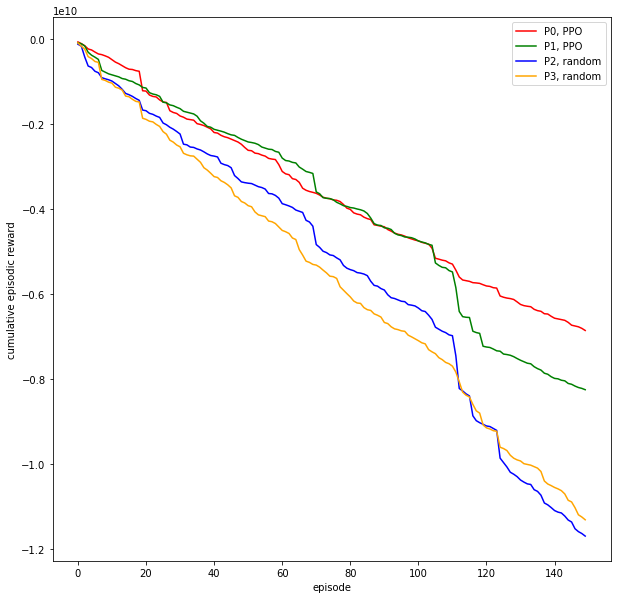

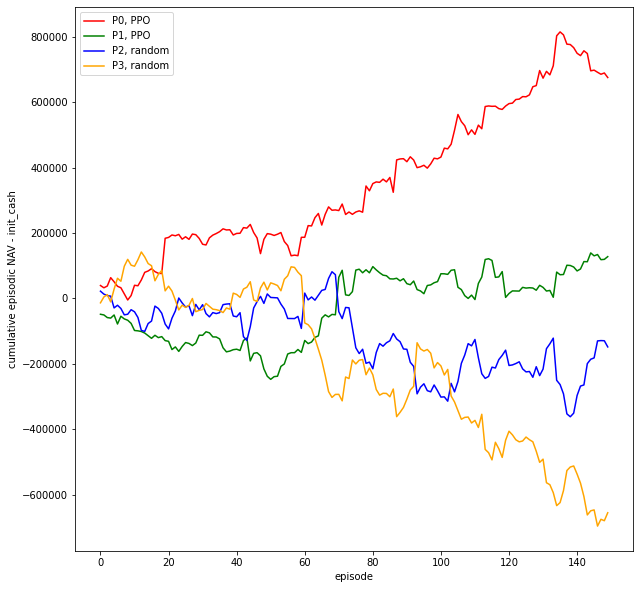

In [17]:
"""
Plot episodic results
"""

import matplotlib.pyplot as plt

def plot_result(x,p0,p1,p2,p3,x_msg,y_msg):

    plt.figure(figsize=(10,10))

    plt.xlabel(x_msg)
    plt.ylabel(y_msg)

    plt.plot(x, p0, 'r', label='P0, PPO') # plotting x, y
    plt.plot(x, p1, 'g', label='P1, PPO') 
    plt.plot(x, p2, 'b', label='P2, random') 
    plt.plot(x, p3, 'orange', label='P3, random') 

    plt.legend()
    plt.show()

x = range(num_iters)
p0 = np.cumsum(agt_0_reward_list)
p1 = np.cumsum(agt_1_reward_list)
p2 = np.cumsum(agt_2_reward_list)
p3 = np.cumsum(agt_3_reward_list)
plot_result(x,p0,p1,p2,p3,'episode','cumulative episodic reward')

x = range(num_iters)

p0 = np.cumsum([value - init_cash for value in agt_0_NAV_list])
p1 = np.cumsum([value - init_cash for value in agt_1_NAV_list])
p2 = np.cumsum([value - init_cash for value in agt_2_NAV_list])
p3 = np.cumsum([value - init_cash for value in agt_3_NAV_list])
plot_result(x,p0,p1,p2,p3,'episode','cumulative episodic NAV - init_cash')